# The Porto Seguro kaggle challenge

## 1. Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., `ind` , `reg`, `car`, `calc`). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

## 2. File descriptions

- `train.csv` contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- `test.csv` contains the test data.

## 3. Aim

- Build a classifier using the training dataset that leads to a good ROC and Precision / Recall curve on the testing set
- The notebook should describe your steps, explain what you do and should run entirely without bugs. It should contain some descriptive statistics and quick study, to understand some things about the data...
- It must end with plots of the ROC and precision/recall curves obtained on the testing dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Use the path to your filename
path = '.'
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## 4. Principal Component Analysis

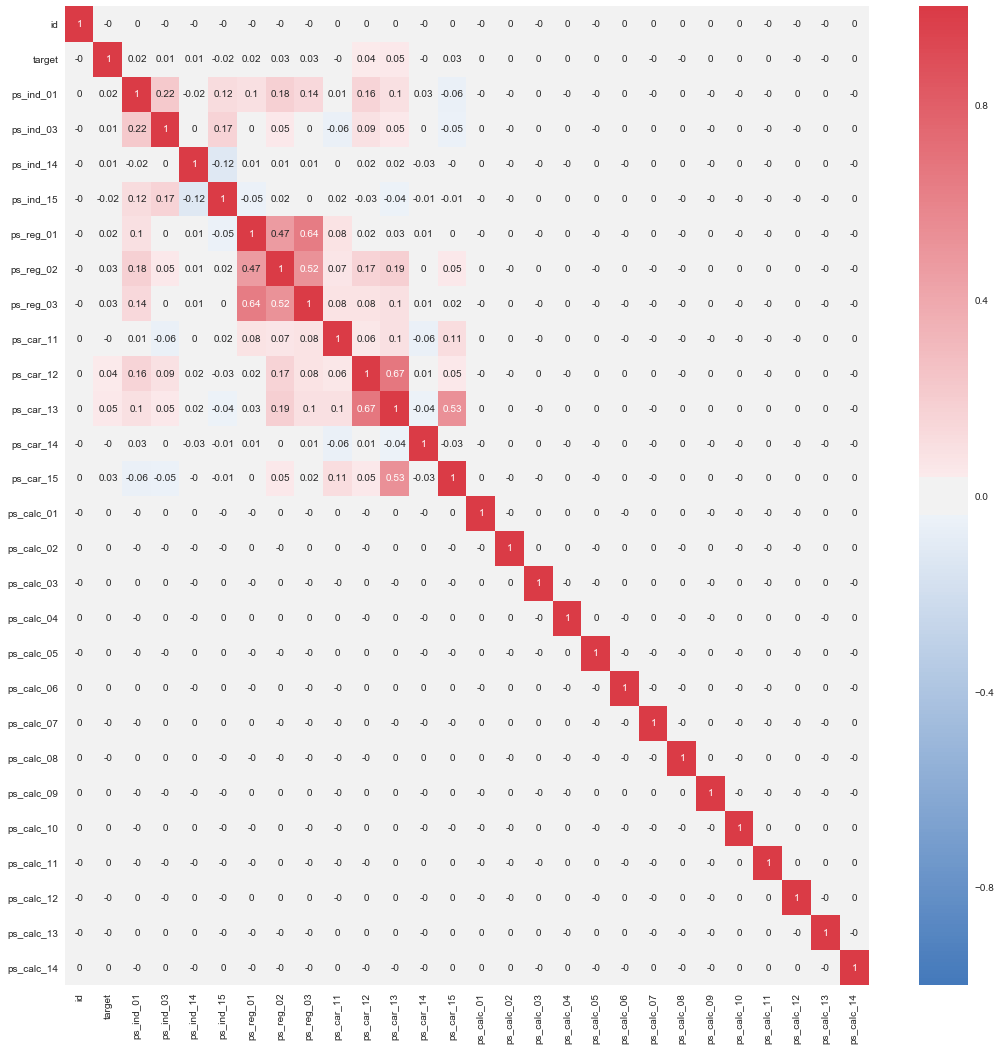

In [3]:
num_featnames = [a for a in train.columns 
                 if not (a.endswith('bin') or a.endswith('cat'))]
# correlation matrix
cor_matrix = train[num_featnames].corr().round(2)
# matrix visualization (Heatmap) 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

This basic Principal Component Analysis shows that few features are actually correlated. We can therefore reduce the dimensions of the problem by restricting the study to the correlated features without losing much of the information.

## 5. Feature engineering

In [4]:
# Dropping 'ps_calc_*' features
train = train.drop(train.columns[train.columns.str.startswith('ps_calc')], axis=1)
test = test.drop(test.columns[test.columns.str.startswith('ps_calc')], axis=1)
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368782,3.316625
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,2.000000,1.000000,93.000000,3.000000,0.400000,0.906190,0.396485,3.605551
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,4.000000,2.000000,104.000000,3.000000,1.264911,3.720626,0.636396,3.741657


### Some initial remarks :
#### 1- reg variables
Only *ps_reg_03* has missing values
the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.
#### 2- car variables
*ps_car_12* and *ps_car_15* have missing values. Again, the range differs and we could apply scaling.
#### 3- The mean of target is 3.645%, which is strongly imbalanced. 
As shown below, for most samples, the target is zero. In other words, there are very few claims, which is natural.

0    573518
1     21694
Name: target, dtype: int64

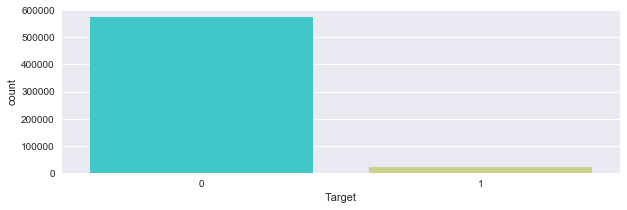

In [5]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

### Exploratory Data Visualization :


**1.** As we can see below from the features with missing values, it is important to keep the missing values as a separate category value, instead of replacing them. Indeed, the customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

**2.** We can also see that *ps_car_11_cat* has many distinct values (precisely 104 distinct values), although it is still reasonable. As we will create dummy variables from the categorical variables later on, we need to check whether there are features with many distinct values. We should handle these features differently as they would result in many dummy variables.


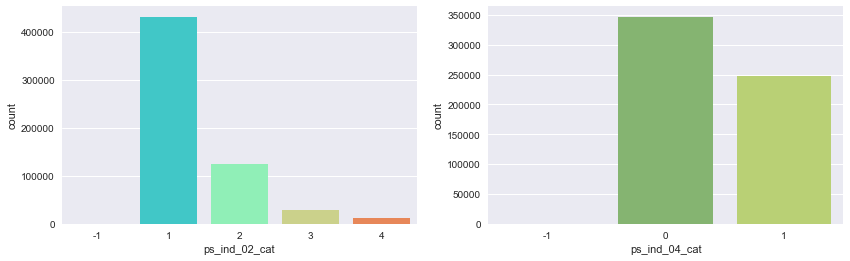

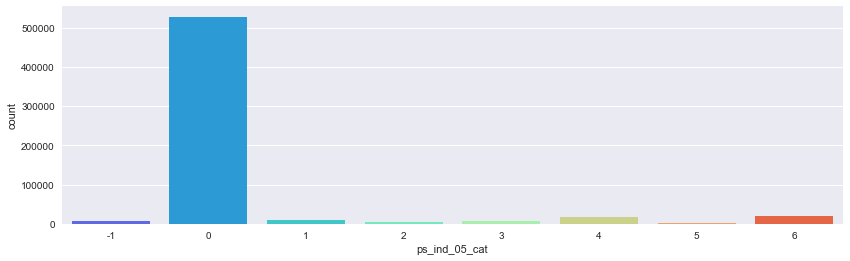

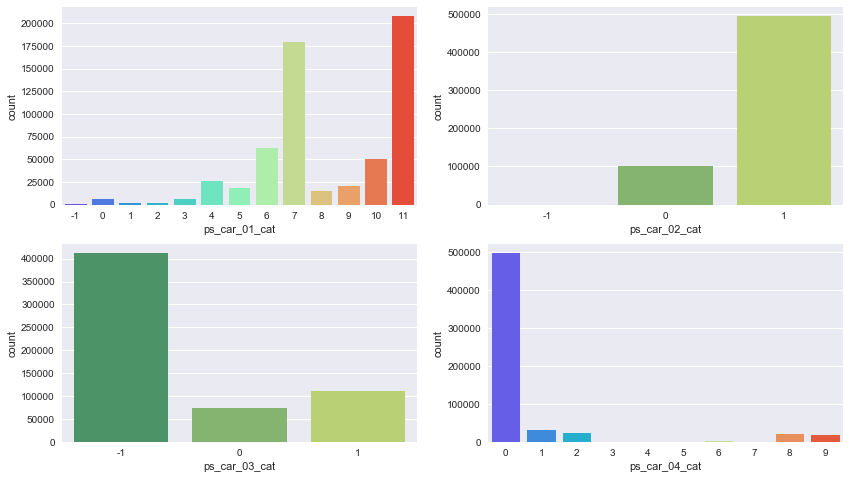

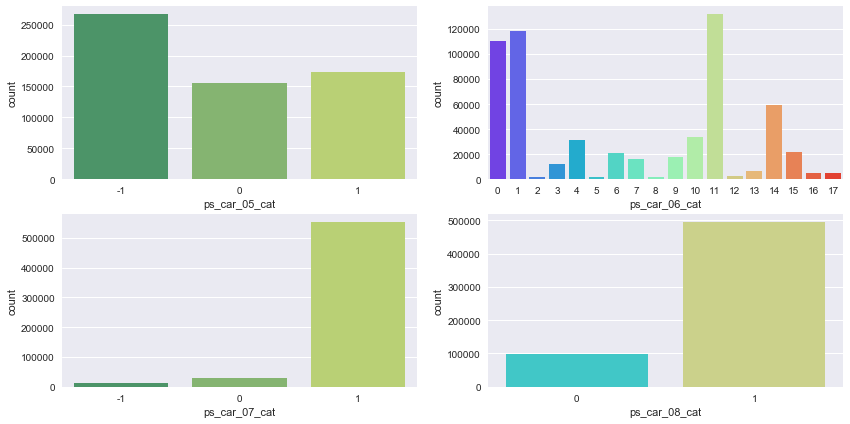

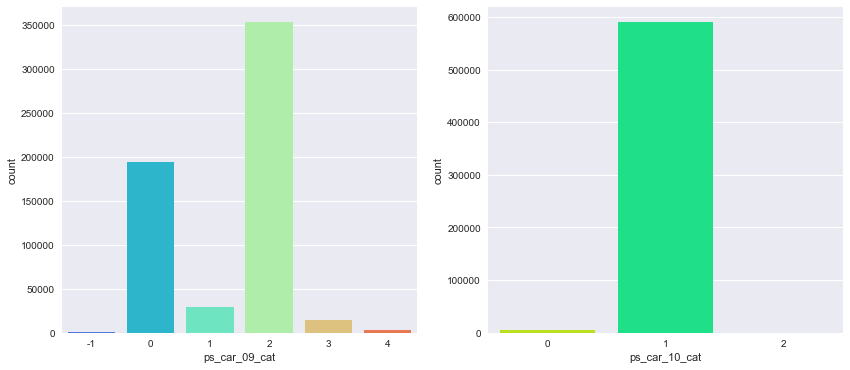

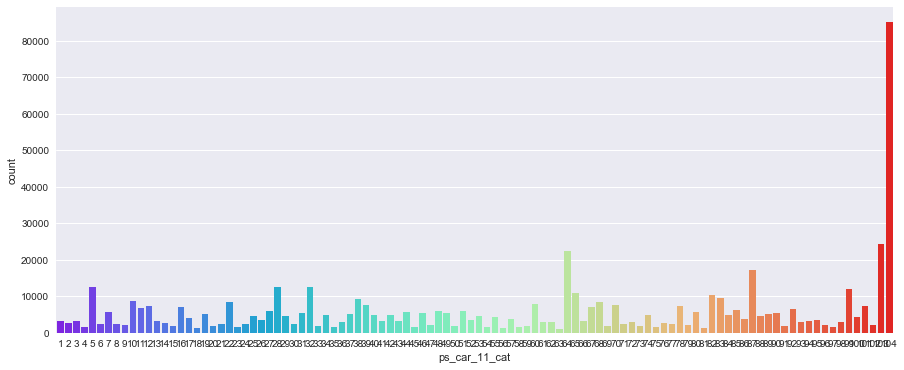

In [6]:
fig ,ax = plt.subplots(1,2,figsize=(14,4))
ax1,ax2, = ax.flatten()
sns.countplot(train['ps_ind_02_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_ind_04_cat'],palette='summer',ax=ax2)
fig,ax = plt.subplots(figsize=(14,4))
sns.countplot(train['ps_ind_05_cat'],palette='rainbow',ax=ax)

fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_01_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_car_02_cat'],palette='summer',ax=ax2)
sns.countplot(train['ps_car_03_cat'],palette='summer',ax=ax3)
sns.countplot(train['ps_car_04_cat'],palette='rainbow',ax=ax4)

fig,ax = plt.subplots(2,2,figsize = (14,7))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_05_cat'],palette='summer',ax=ax1)
sns.countplot(train['ps_car_06_cat'],palette='rainbow',ax=ax2)
sns.countplot(train['ps_car_07_cat'],palette='summer',ax=ax3)
sns.countplot(train['ps_car_08_cat'],palette='rainbow',ax=ax4)

fig, ax = plt.subplots(1,2,figsize=(14,6))
ax1,ax2 = ax.flatten()
sns.countplot(train['ps_car_09_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_car_10_cat'],palette='gist_rainbow',ax=ax2)
fig,ax = plt.subplots(figsize=(15,6))
sns.countplot(train['ps_car_11_cat'],palette='rainbow',ax=ax)

### Preparation of the dataset for learning :

In [7]:
# extracting target column and dropping target and id from training dataset
target = train['target'].values
id_test = test['id'].values
train = train.drop(['target', 'id'], axis = 1)
test = test.drop(['id'], axis = 1)

In [8]:
# processing missing values
#train = train.replace(-1, np.nan)
#test = test.replace(-1, np.nan)

# processing categorical features
cat_featnames = [a for a in train.columns if (a.endswith('cat') and a != 'ps_car_11_cat')]
for feature in cat_featnames:
    tmp = pd.get_dummies(pd.Series(train[feature]))
    train = pd.concat([train,tmp],axis=1)
    train = train.drop([feature],axis=1) 
for feature in cat_featnames:
    tmp = pd.get_dummies(pd.Series(test[feature]))
    test = pd.concat([test,tmp],axis=1)
    test = test.drop([feature],axis=1)

In [9]:
train.values.shape

(595212, 104)

## 6. Ensemble learning

In [10]:
# Adapted from https://www.kaggle.com/yekenot/simple-stacker-lb-0-284

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        self.y_pred = np.empty([1,1])

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
#                y_holdout = y[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("    cross_score: %.5f" % (cross_score.mean()))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        self.y_pred = self.stacker.predict_proba(S_test)[:,1]
        return self.y_pred

In [11]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 650
lgb_params['max_bin'] = 10
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 500
lgb_params['random_state'] = 99

lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['random_state'] = 99

lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['random_state'] = 99

In [12]:
# Models

lgb_model = LGBMClassifier(**lgb_params)

lgb_model2 = LGBMClassifier(**lgb_params2)

lgb_model3 = LGBMClassifier(**lgb_params3)

ada_model = AdaBoostClassifier()

log_model = LogisticRegression()

### Training the model

In [13]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model, lgb_model2, lgb_model3, ada_model,
                       log_model
                      ))        
        
y_pred = stack.fit_predict(train, target, train)

Fit LGBMClassifier fold 1
    cross_score: 0.64218
Fit LGBMClassifier fold 2
    cross_score: 0.63956
Fit LGBMClassifier fold 3
    cross_score: 0.63835
Fit LGBMClassifier fold 1
    cross_score: 0.64215
Fit LGBMClassifier fold 2
    cross_score: 0.64044
Fit LGBMClassifier fold 3
    cross_score: 0.63974
Fit LGBMClassifier fold 1
    cross_score: 0.64069
Fit LGBMClassifier fold 2
    cross_score: 0.63811
Fit LGBMClassifier fold 3
    cross_score: 0.63743
Fit AdaBoostClassifier fold 1
    cross_score: 0.63152
Fit AdaBoostClassifier fold 2
    cross_score: 0.63061
Fit AdaBoostClassifier fold 3
    cross_score: 0.63021
Fit LogisticRegression fold 1
    cross_score: 0.62982
Fit LogisticRegression fold 2
    cross_score: 0.63003
Fit LogisticRegression fold 3
    cross_score: 0.62924
Stacker score: 0.64269


### Saving the model

In [14]:
import pickle
with open('model.pkl', 'wb') as output:
    pickle.dump(stack, output, pickle.HIGHEST_PROTOCOL)
    output.close()

## 7. Precision evaluation

In [15]:
import pickle
with open('model.pkl', 'rb') as input_file:
    stack = pickle.load(input_file)
    input_file.close()

### ROC Curve

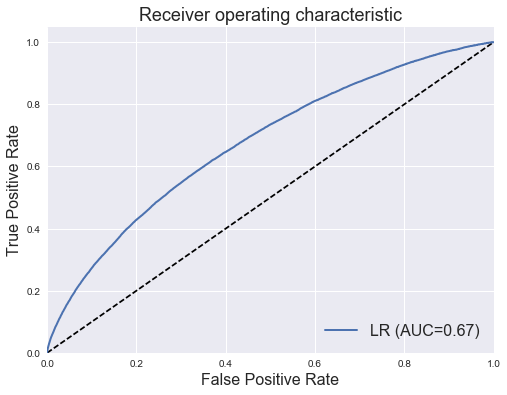

In [16]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(target, stack.y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="LR (AUC=%.2f)" % roc_auc, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right", fontsize=16)

As demonstrated by the AUC scores, the ensembled classifier outperfoms all the individual classifiers used to build it.

### Precision/Recall

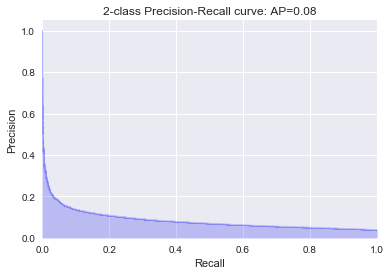

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(target, stack.y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
average_precision = average_precision_score(target, stack.y_pred)
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

The Precision/Recall curve is not very high, which is to be expected given how skewed the dataset is (the probability of a true claim being very small).